In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    get_lin_var,
    get_lin_var_small_delay,
    get_theo_var_l_two_time,
    get_eq_times,
)
from functions import SolverManager, EigenvectorManager, SimulationManager

from setup import (
    setup_matplotlib,
    one_col,
    std_height,
    two_col,
    sim_plt_set,
    num_plt_set,
    eigenv_plt_set,
    exact_plt_set,
    short_plt_set,
)
from timeit import default_timer as timer

setup_matplotlib()
with_legend = True
np.random.seed(42)

(Path.cwd()/"graphics"/"additional").mkdir(exist_ok=True, parents=True)

In [54]:
s = 1
D = s**2 / 2
max_t = 10
ntau = 3  # 2 #3
N_x = 41  # 61 #81 #41
eq_perc = 0.75
hist_sigma = 4
avg_part = 4
force = "linear"

if force == "linear":
    a = 0.0
    b = 1.0
elif force == "general":
    a = 1.0
    b = 1.0

N_p = 2_000
N_loop = 10

ntau_sim = 30

ltaus = np.concatenate(([0, 0.02, 0.05, 0.1], np.arange(0.2, 2.2, 0.1)))
sbs = np.empty(len(ltaus))
sim_vars = np.empty((len(ltaus), 4))
sim_eq_time = np.empty((len(ltaus), 2))

num_vars = np.empty((len(ltaus), 4))
num_eq_time = np.empty((len(ltaus), 2))

non_div_taus = (
    ltaus[ltaus < np.arccos(-a / b) / np.sqrt(b**2 - a**2)] if a < b else ltaus
)

eig_vars = np.empty((len(non_div_taus), 2))
num_timings = np.empty(len(ltaus))
sim_timings = np.empty(len(ltaus))
eig_timings = np.empty(len(non_div_taus))

num_N_t_s = np.empty(len(ltaus))
sim_N_t_s = np.empty(len(ltaus))

In [55]:
test_ltaus = np.arange(0, non_div_taus[-1], 0.025)
exact_eqtimes = np.array([get_eq_times(ltau, D, eq_perc, a, b) for ltau in test_ltaus])

In [56]:
my_sim_manager = SimulationManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
    N_t = int(max_t / ldt) + 1
    sim_N_t_s[i] = N_t

    ntau_arg = ntau_sim if ltau > 0 else 0

    res = my_sim_manager.run(
        N_p=N_p,
        N_loop=N_loop,
        N_t=N_t,
        N_x=N_x,
        ntau=ntau_arg,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        hist_sigma=hist_sigma,
    )
    sim_timings[i] = my_sim_manager.get_timing()

    sim_ts = np.arange(0, (N_t + ntau_sim)) * ldt - ltau

    sim_var = res["sim_var"]
    x_s = res["x_s"]
    sbs[i] = -x_s[0]

    mean_sim_vars = np.mean(sim_var[:, -N_t // avg_part :], axis=1)
    sim_vars[i] = (
        np.mean(mean_sim_vars),
        np.std(mean_sim_vars) / np.sqrt(N_loop),
        np.min(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
    )

    mean_s_eq = sim_ts[
        np.argmin((eq_perc * mean_sim_vars[:, None] - sim_var) ** 2, axis=1)
    ]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq) / np.sqrt(N_loop))

100%|██████████| 24/24 [00:00<00:00, 692.59it/s]


In [57]:
my_num_manager = SolverManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    N_t = int(max_t / ldt) + 1
    num_N_t_s[i] = N_t

    ts = np.arange(0, N_t) * ldt

    sb = sbs[i]

    res = my_num_manager.run(
        N_t=N_t,
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
    )
    num_timings[i] = my_num_manager.get_timing()

    num_var = res["num_var"]

    mean_num_var = np.mean(num_var[-N_t // avg_part :])
    num_vars[i] = (
        mean_num_var,
        0,
        np.min(num_var[-N_t // avg_part :]),
        np.max(num_var[-N_t // avg_part :]),
    )
    num_eq_time[i] = ts[np.argmin((eq_perc * mean_num_var - num_var) ** 2)]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [11:28<00:00, 28.70s/it]


In [58]:
eigen_manager = EigenvectorManager()

for i, ltau in enumerate(tqdm(non_div_taus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    sb = sbs[i]

    if ltau > 0:
        res = eigen_manager.run(
            N_x=N_x, sb=sb, ntau=ntau, s=s, dt=ldt, force=force
        )
    else:
        res = eigen_manager.run(
            N_x=N_x, sb=sb, ntau=0, s=s, dt=ldt, force=force
        )
    eig_timings[i] = eigen_manager.get_timing()

    eig_vars[i] = (res["eig_var"], 0)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [10:34<00:00, 35.25s/it]


In [59]:
short_time_approx_var = get_lin_var_small_delay(non_div_taus, a, b, s)
exact_sol = get_lin_var(non_div_taus, a, b, s)
exact_sol_times = np.linspace(0, max_t, 1000)
exact_sol_dyn_raw = np.stack(
    [
        get_theo_var_l_two_time(exact_sol_times, tau, D, a=a, b=b)[
            -len(exact_sol_times) // avg_part :
        ]
        for tau in ltaus
    ]
)
exact_sol_dyn = np.stack(
    (
        np.nanmean(exact_sol_dyn_raw, axis=1),
        np.zeros(exact_sol_dyn_raw.shape[0]),
        np.nanmin(exact_sol_dyn_raw, axis=1),
        np.nanmax(exact_sol_dyn_raw, axis=1),
    )
).T

/tmp/ipykernel_7275/3934319887.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(exact_sol_dyn_raw, axis=1),
/tmp/ipykernel_7275/3934319887.py:16: RuntimeWarning: All-NaN slice encountered
  np.nanmin(exact_sol_dyn_raw, axis=1),
/tmp/ipykernel_7275/3934319887.py:17: RuntimeWarning: All-NaN slice encountered
  np.nanmax(exact_sol_dyn_raw, axis=1),


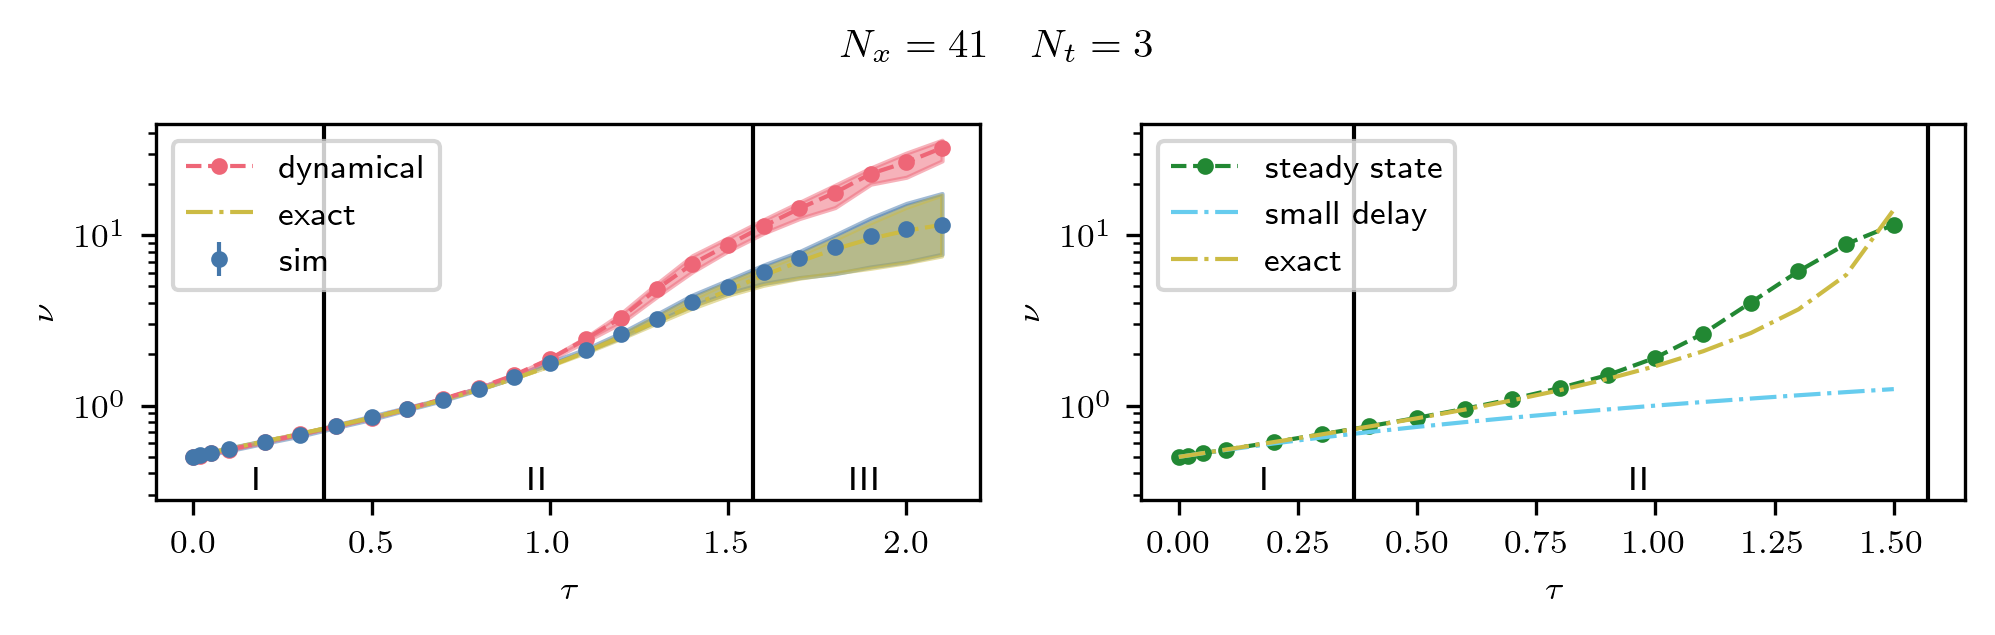

In [60]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
if force == "linear":
    plt.yscale("log")
plt.errorbar(ltaus, sim_vars[:, 0],sim_vars[:, 1], **sim_plt_set)
plt.fill_between(ltaus, sim_vars[:, 2], sim_vars[:, 3], alpha=0.5, color="C0")
plt.plot(ltaus, num_vars[:, 0], **num_plt_set)
plt.fill_between(ltaus, num_vars[:, 2], num_vars[:, 3], alpha=0.5, color="C1")
plt.plot(ltaus, exact_sol_dyn[:, 0], **exact_plt_set)
plt.fill_between(ltaus, exact_sol_dyn[:, 2], exact_sol_dyn[:, 3], alpha=0.5, color="C3")

if force == "linear":
    plt.ylim(0.7 * plt.ylim()[0], plt.ylim()[1])
    y = plt.ylim()[0] * 1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "II", ha="center", va="center")
    plt.text(0.5 * (np.pi / 2 + plt.xlim()[1]), y, "III", ha="center", va="center")
if with_legend:
    plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")
ylim = plt.ylim()

ax = plt.subplot(122)
if force == "linear":
    plt.yscale("log")
plt.ylim(*ylim)
plt.plot(non_div_taus, eig_vars[:, 0], **eigenv_plt_set)
if force == "linear":
    plt.plot(non_div_taus, short_time_approx_var, **short_plt_set)
plt.plot(non_div_taus, exact_sol, **exact_plt_set)

if force == "linear":
    y = plt.ylim()[0] * 1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "II", ha="center", va="center")

if with_legend:
    plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")
plt.suptitle(f"$N_x = {N_x} \quad N_t = {ntau}$")

plt.tight_layout()
if with_legend:
    plt.savefig(f"graphics/x2var_{force}_Nx{N_x}_Nt{ntau}.pdf")
else:
    plt.savefig(f"graphics/x2var_{force}_Nx{N_x}_Nt{ntau}_no_legend.pdf")

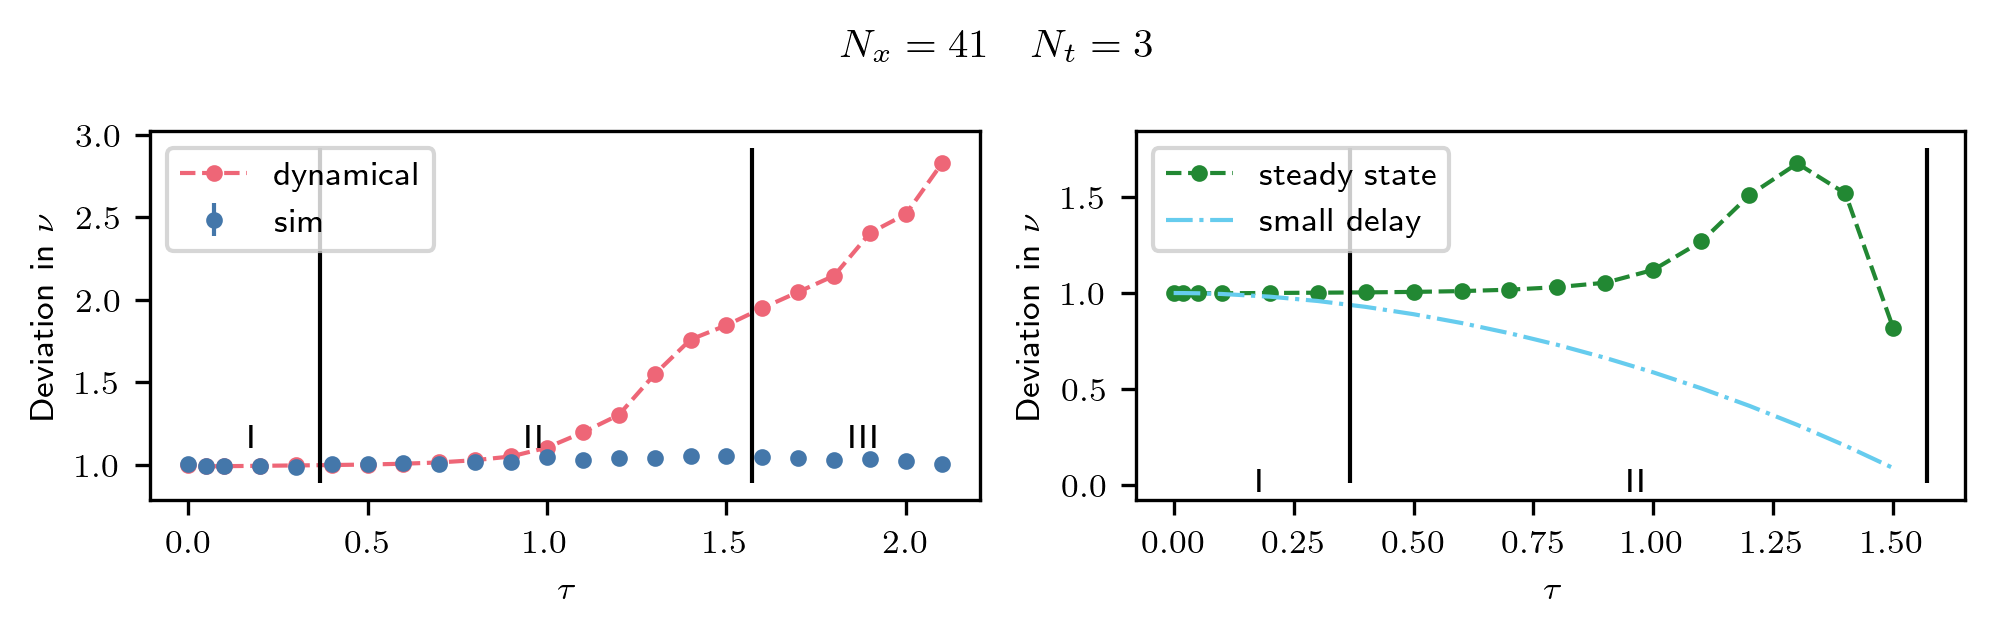

In [61]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
plt.errorbar(ltaus, sim_vars[:, 0]/exact_sol_dyn[:, 0],sim_vars[:, 1]/exact_sol_dyn[:, 0], **sim_plt_set)
plt.plot(ltaus, num_vars[:, 0]/exact_sol_dyn[:, 0], **num_plt_set)

if force == "linear":
    y = plt.ylim()[0] * 1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "II", ha="center", va="center")
    plt.text(0.5 * (np.pi / 2 + plt.xlim()[1]), y, "III", ha="center", va="center")
if with_legend:
    plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"Deviation in $\nu$")


ax = plt.subplot(122)

plt.plot(non_div_taus, eig_vars[:, 0]/exact_sol, **eigenv_plt_set)
if force == "linear":
    plt.plot(non_div_taus, short_time_approx_var/exact_sol, **short_plt_set)

if force == "linear":
    y = plt.ylim()[0] * 1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "II", ha="center", va="center")

if with_legend:
    plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"Deviation in $\nu$")
plt.suptitle(f"$N_x = {N_x} \quad N_t = {ntau}$")

plt.tight_layout()

if with_legend:
    plt.savefig(f"graphics/additional/x2var_{force}_Nx{N_x}_Nt{ntau}_deviation.pdf")

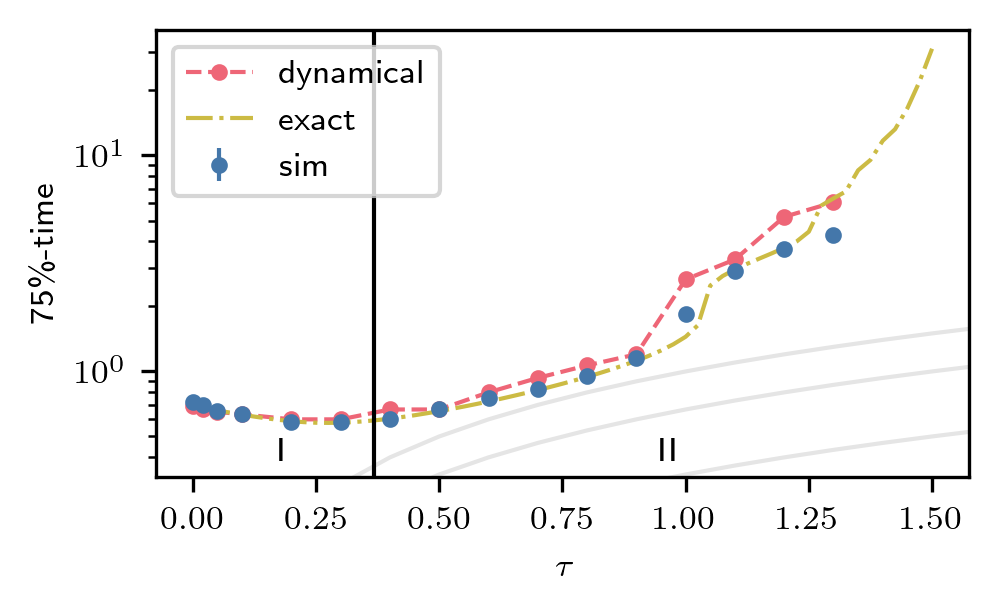

In [62]:
# Only if system was able to reach steady state
eq_perc = 0.75
eq_f = 0.75
q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)
max_t_eq = test_ltaus[(exact_eqtimes * q_f) < (max_t - max_t / avg_part)][-1]
cond = ltaus <= max_t_eq
plt.errorbar(ltaus[cond], *sim_eq_time[cond].T, **sim_plt_set)
plt.plot(ltaus[cond], num_eq_time[cond, 0], **num_plt_set)
plt.plot(test_ltaus, exact_eqtimes, **exact_plt_set)

plt.yscale("log")
# plt.ylim(3e-1, 2e1)
if force == "linear":
    plt.ylim(0.7 * plt.ylim()[0], plt.ylim()[1])
    y = plt.ylim()[0] * 1.3
    plt.vlines([1 / np.e], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "II", ha="center", va="center")

plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())
for i in range(4):
    plt.plot(ltaus, ltaus / ntau * i, color="black", alpha=0.1)

if with_legend:
    plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"75\%-time")
plt.tight_layout()
if with_legend:
    plt.savefig(f"graphics/x2eqtime_{force}_Nx{N_x}_Nt{ntau}.pdf")

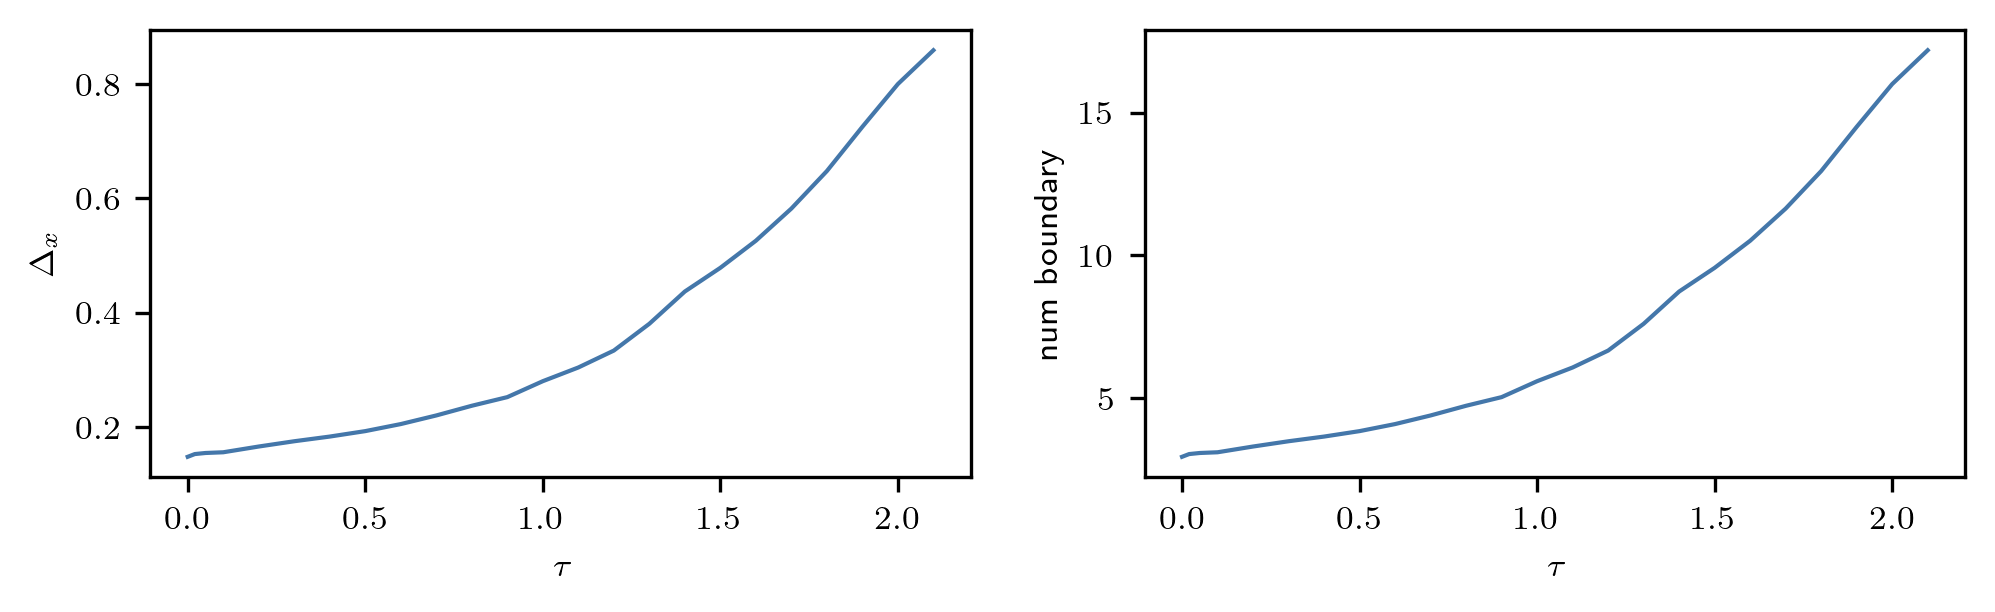

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(two_col, std_height))
axs[0].plot(ltaus, 2 * sbs / (N_x - 1))
axs[0].set_xlabel(r"$\tau$")
axs[0].set_ylabel(r"$\Delta_x$")

axs[1].plot(ltaus, sbs)
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel(r"num boundary")

plt.tight_layout()

/tmp/ipykernel_7275/280983640.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


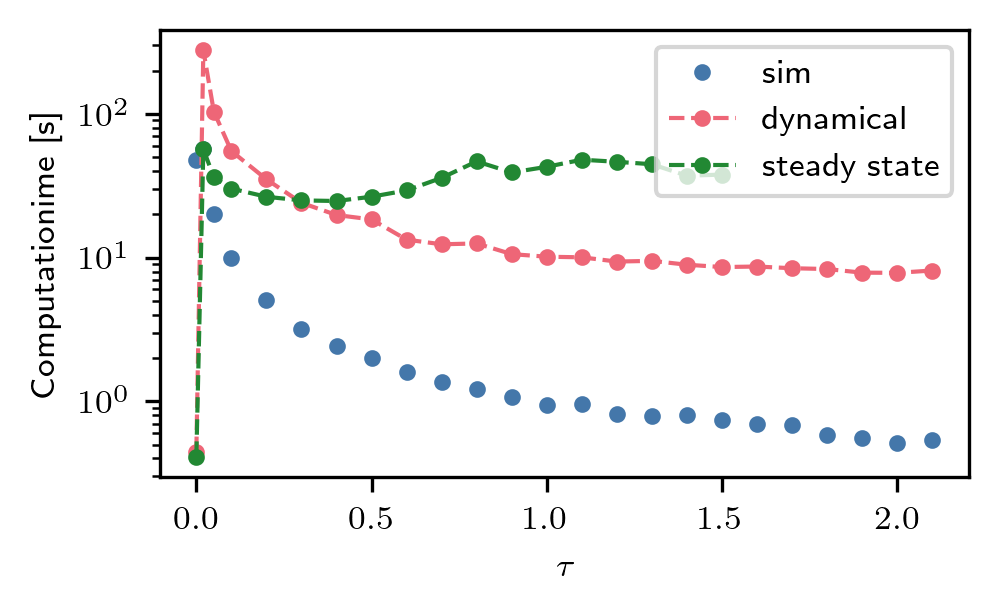

In [64]:
plt.plot(ltaus, sim_timings, **sim_plt_set)
plt.plot(ltaus, num_timings, **num_plt_set)
plt.plot(non_div_taus, eig_timings, **eigenv_plt_set)
if with_legend:
    plt.legend()
plt.yscale("log")
plt.tight_layout()
plt.ylabel("Computationime [s]")
plt.xlabel(r"$\tau$")
plt.tight_layout()
if with_legend:
    plt.savefig(f"graphics/additional/timing_{force}_Nx{N_x}_Nt{ntau}.pdf")

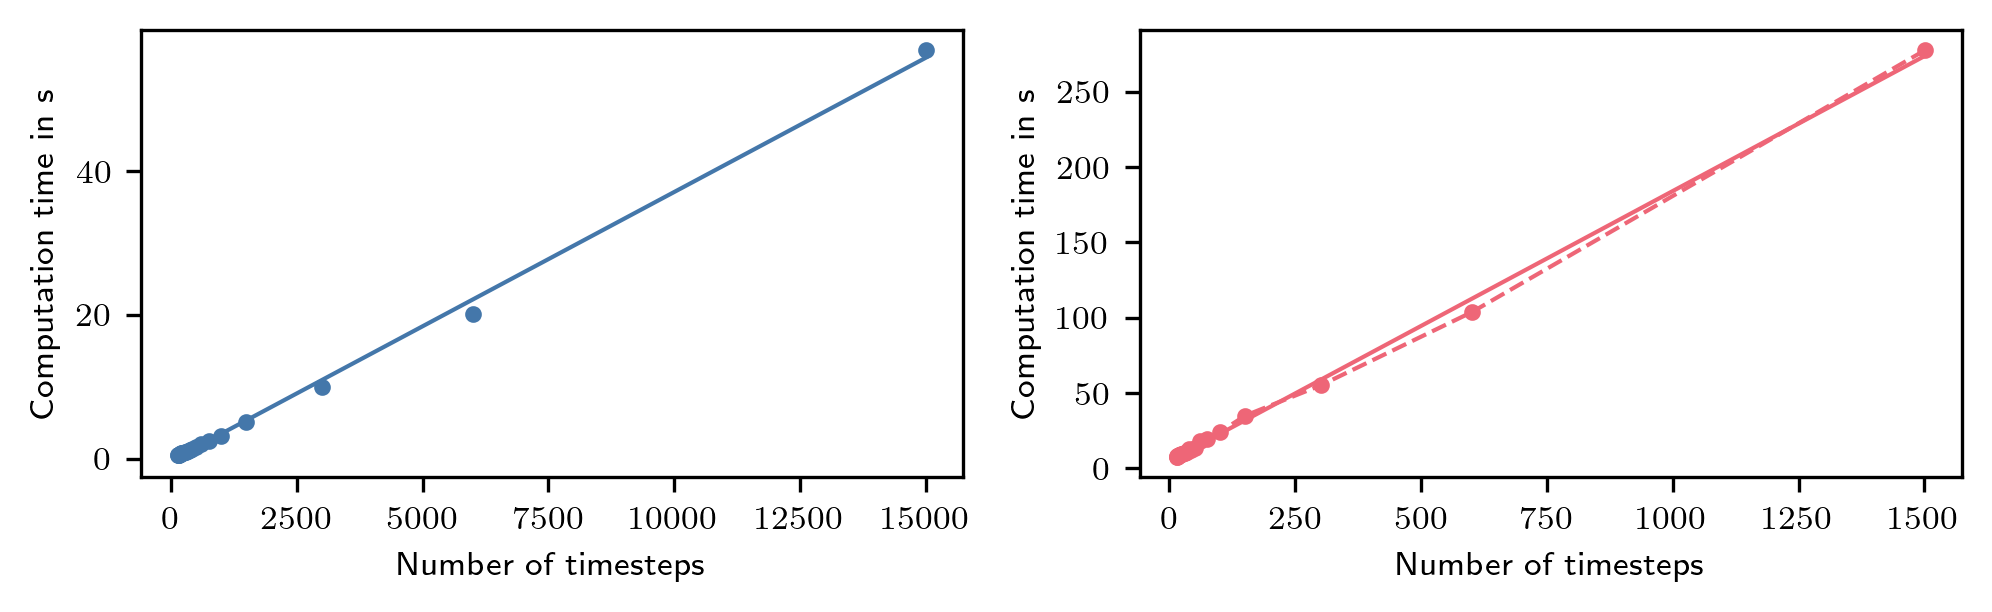

In [65]:
sim_m, sim_b = np.polyfit(sim_N_t_s[1:], sim_timings[1:], deg=1)
num_m, num_b = np.polyfit(num_N_t_s[1:], num_timings[1:], deg=1)


plt.figure(figsize=(two_col, std_height))
plt.subplot(121)
plt.plot(sim_N_t_s[1:], sim_timings[1:], **sim_plt_set)
plt.plot(sim_N_t_s[1:], sim_m * sim_N_t_s[1:] + sim_b)
plt.xlabel('Number of timesteps')
plt.ylabel('Computation time in s')
plt.subplot(122)
plt.plot(num_N_t_s[1:], num_timings[1:], **num_plt_set)
plt.plot(num_N_t_s[1:], num_m * num_N_t_s[1:] + num_b, color="C1")
plt.xlabel('Number of timesteps')
plt.ylabel('Computation time in s')
plt.tight_layout()

In [66]:
timing_all = [
    round(sim_b, 3),
    round(sim_m, 3),
    round(sim_m * ntau_sim, 3),
    round(num_b, 3),
    round(num_m, 3),
    round(num_m * ntau, 3),
    round(np.mean(eig_timings[1:]), 3),
]

print("Simulation setup \t", timing_all[0])
print("Simulation Iteration \t", timing_all[1])
print("Simulation per interval \t", timing_all[2])
print("-----------------------")
print("Numerical setup \t", timing_all[3])
print("Numerical Iteration \t", timing_all[4])
print("Numerical per interval \t", timing_all[5])
print("-----------------------")
print("Steady state overall \t", timing_all[6])

Simulation setup 	 -0.254
Simulation Iteration 	 0.004
Simulation per interval 	 0.112
-----------------------
Numerical setup 	 4.997
Numerical Iteration 	 0.179
Numerical per interval 	 0.537
-----------------------
Steady state overall 	 37.29


In [67]:
print(f"N_x = {N_x}, N_t = {ntau}")
print('\n'.join([str(o) for o in timing_all]))

N_x = 41, N_t = 3
-0.254
0.004
0.112
4.997
0.179
0.537
37.29
